In [7]:
# Mall Customer Segmentation and Classification
# Implementing K-means, Hierarchical Clustering, and Linear SVM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

In [8]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Option 1: Use the updated matplotlib style name
try:
    plt.style.use('seaborn-v0_8-whitegrid')  # For transitional versions
except:
    # Fallback to a default style with grid
    plt.style.use('default')
    plt.rcParams['axes.grid'] = True

# Option 2 (recommended): Use seaborn's own styling function
# sns.set_theme(style="whitegrid")

# Set the color palette
sns.set_palette("Set2")

In [9]:
# 1. Load and prepare the data
# ===========================

# Read the data
df = pd.read_csv('Datasets/mall.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# We'll use 'Annual Income' and 'Spending Score' for our clustering
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

# Scaling the data for consistent analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Dataset Shape: (200, 5)

First 5 rows:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


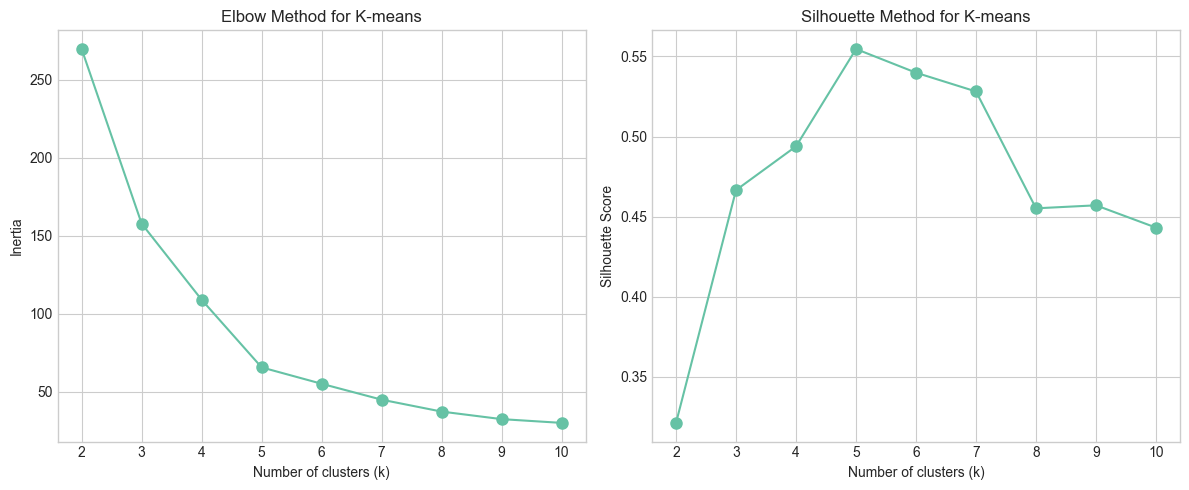

Optimal number of clusters for K-means: 5


In [10]:
# 2. K-means Clustering
# =====================

# a. Find the optimal number of clusters
# -------------------------------------

# Calculate inertia (within-cluster sum of squares) for different k values
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot the Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-', markersize=8)
plt.title('Elbow Method for K-means')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

# Plot the Silhouette Method
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-', markersize=8)
plt.title('Silhouette Method for K-means')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Based on the results, we determine the optimal k
optimal_k = 5  # This can be adjusted based on the elbow/silhouette plots
print(f"Optimal number of clusters for K-means: {optimal_k}")

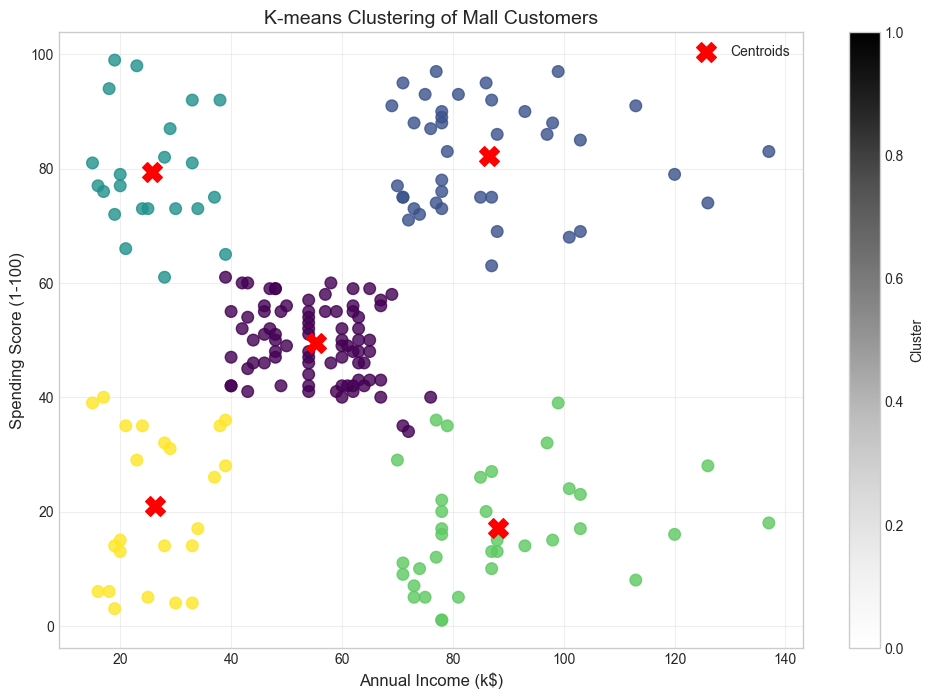


K-means Cluster Statistics:


,Age_mean,Age_min,Age_max,Annual Income (k$)_mean,Annual Income (k$)_min,Annual Income (k$)_max,Spending Score (1-100)_mean,Spending Score (1-100)_min,Spending Score (1-100)_max,Customer_Count
KMeans_Cluster,,,,,,,,,,
0,42.72,18,70,55.30,39,76,49.52,34,61,81
1,32.69,27,40,86.54,69,137,82.13,63,97,39
2,25.27,18,35,25.73,15,39,79.36,61,99,22
3,41.11,19,59,88.20,70,137,17.11,1,39,35
4,45.22,19,67,26.30,15,39,20.91,3,40,23


In [13]:
# b. Visualize the clusters
# ------------------------

# Apply K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original data
df['KMeans_Cluster'] = kmeans_labels

# Plot the clusters
plt.figure(figsize=(12, 8))

# Original data scale for easier interpretation
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=70, alpha=0.8)

# Transform centroids back to original scale before plotting
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids_original[:, 0], centroids_original[:, 1], c='red', 
            marker='X', s=200, label='Centroids')

plt.title('K-means Clustering of Mall Customers', fontsize=14)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend()
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# Descriptive statistics for each cluster
print("\nK-means Cluster Statistics:")
cluster_stats = df.groupby('KMeans_Cluster').agg({
    'Age': ['mean', 'min', 'max'],
    'Annual Income (k$)': ['mean', 'min', 'max'],
    'Spending Score (1-100)': ['mean', 'min', 'max'],
    'CustomerID': 'count'  # Count of customers
}).round(2)

cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]
cluster_stats.rename(columns={'CustomerID_count': 'Customer_Count'}, inplace=True)
display(cluster_stats)

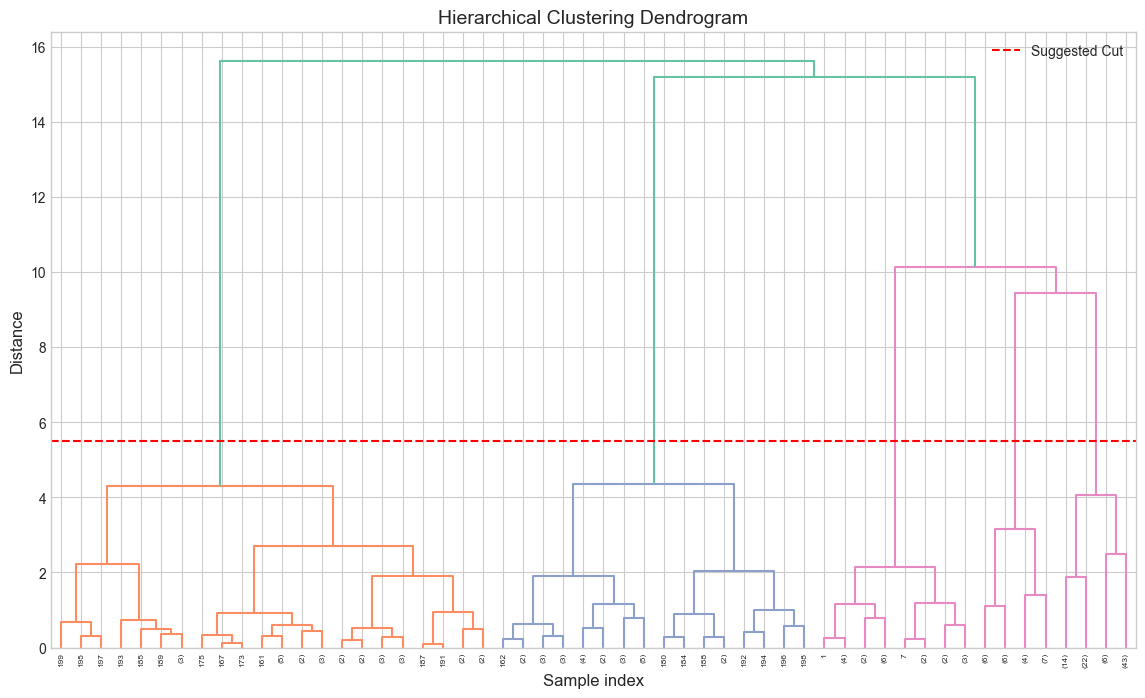

Optimal number of clusters for Hierarchical Clustering: 5


In [14]:
# 3. Hierarchical Clustering
# =========================

# a. Find the optimal number of clusters
# -------------------------------------

# Create a linkage matrix using Ward's method
Z = linkage(X_scaled, method='ward')

# Plot the dendrogram to identify the optimal number of clusters
plt.figure(figsize=(14, 8))
dendrogram_plot = dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Sample index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=5.5, color='r', linestyle='--', label='Suggested Cut')
plt.legend()
plt.show()

# Based on the dendrogram, we determine the optimal number of clusters
optimal_h_clusters = 5  # This can be adjusted based on the dendrogram
print(f"Optimal number of clusters for Hierarchical Clustering: {optimal_h_clusters}")

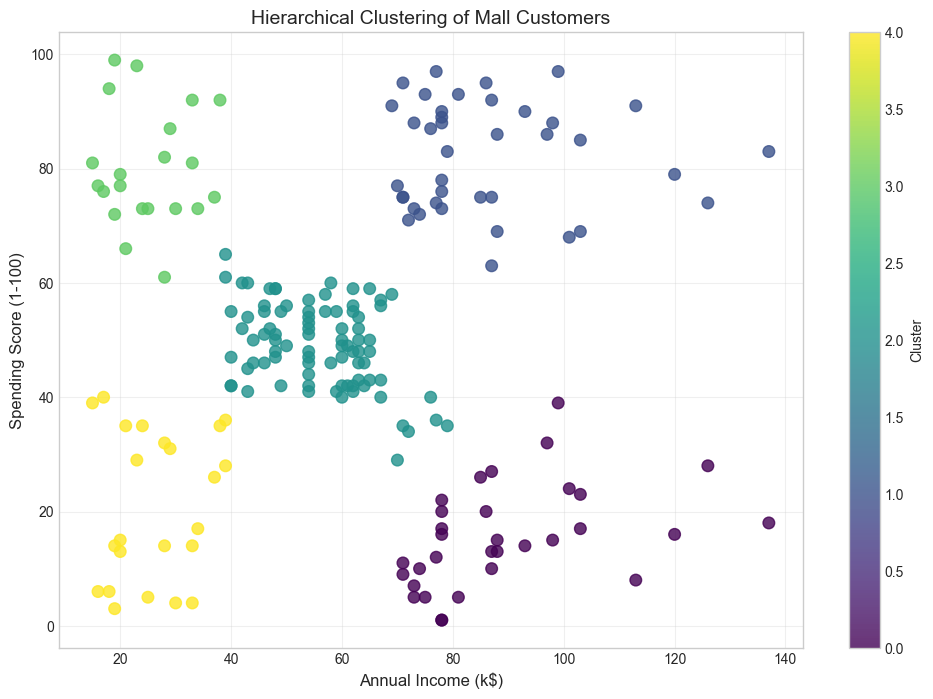


Hierarchical Cluster Statistics:


,Age_mean,Age_min,Age_max,Annual Income (k$)_mean,Annual Income (k$)_min,Annual Income (k$)_max,Spending Score (1-100)_mean,Spending Score (1-100)_min,Spending Score (1-100)_max,Customer_Count
Hierarchical_Cluster,,,,,,,,,,
0,41.00,19,59,89.41,71,137,15.59,1,39,32
1,32.69,27,40,86.54,69,137,82.13,63,97,39
2,42.48,18,70,55.81,39,79,49.13,29,65,85
3,25.33,18,35,25.10,15,38,80.05,61,99,21
4,45.22,19,67,26.30,15,39,20.91,3,40,23


In [15]:
# b. Visualize the clusters
# ------------------------

# Apply Hierarchical Clustering with the optimal number of clusters
hierarchical = AgglomerativeClustering(n_clusters=optimal_h_clusters, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add cluster labels to the original data
df['Hierarchical_Cluster'] = hierarchical_labels

# Plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=hierarchical_labels, cmap='viridis', s=70, alpha=0.8)

plt.title('Hierarchical Clustering of Mall Customers', fontsize=14)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# Descriptive statistics for each cluster
print("\nHierarchical Cluster Statistics:")
h_cluster_stats = df.groupby('Hierarchical_Cluster').agg({
    'Age': ['mean', 'min', 'max'],
    'Annual Income (k$)': ['mean', 'min', 'max'],
    'Spending Score (1-100)': ['mean', 'min', 'max'],
    'CustomerID': 'count'  # Count of customers
}).round(2)

h_cluster_stats.columns = ['_'.join(col).strip() for col in h_cluster_stats.columns.values]
h_cluster_stats.rename(columns={'CustomerID_count': 'Customer_Count'}, inplace=True)
display(h_cluster_stats)


Linear SVM Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      1.00      1.00        12
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         7

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60



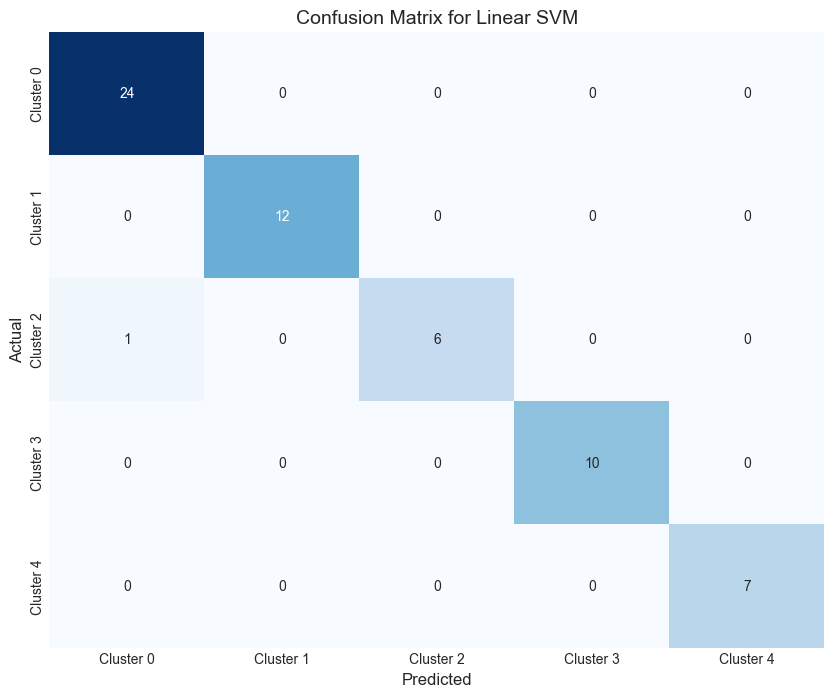

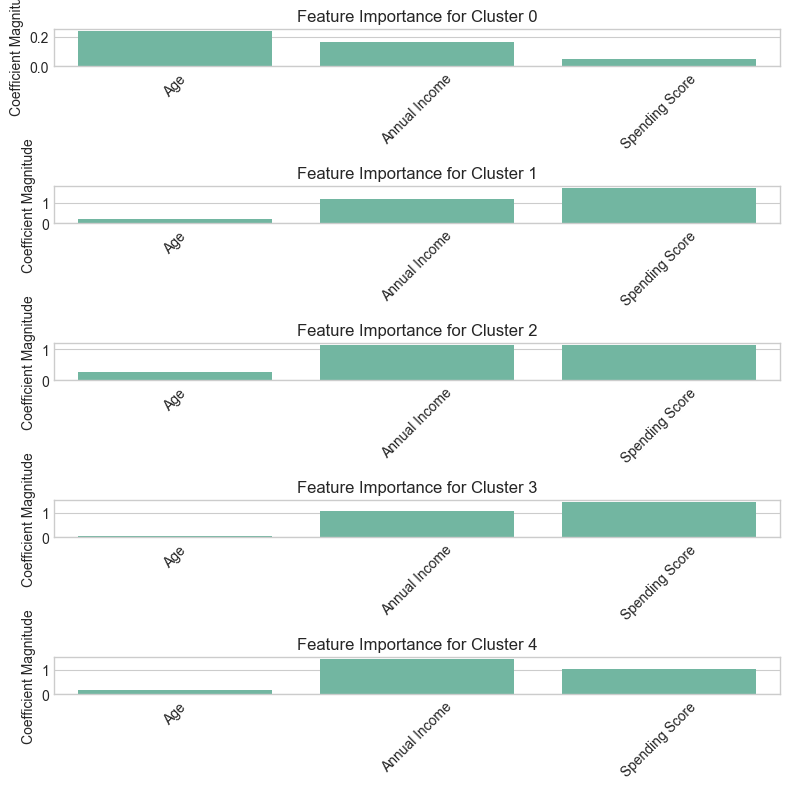

In [19]:
# 4. Linear SVM for Classification
# ===============================

# We'll use the K-means cluster labels as our target for SVM classification
# This is a way to see if we can predict customer segments based on their features

# Prepare features and target
X_features = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values
y_target = df['KMeans_Cluster'].values

# Scale all features for SVM
X_all_scaled = StandardScaler().fit_transform(X_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_all_scaled, y_target, test_size=0.3, random_state=42, stratify=y_target
)

# Train the Linear SVM model
linear_svm = LinearSVC(dual=False, C=1.0, random_state=42)
linear_svm.fit(X_train, y_train)

# Make predictions
y_pred = linear_svm.predict(X_test)

# Evaluate the model
print("\nLinear SVM Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Cluster {i}' for i in range(optimal_k)],
            yticklabels=[f'Cluster {i}' for i in range(optimal_k)])
plt.title('Confusion Matrix for Linear SVM', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# Feature importance (based on coefficient magnitude)
feature_names = ['Age', 'Annual Income', 'Spending Score']
importance = np.abs(linear_svm.coef_)

# Create a plot for feature importance for each cluster
plt.figure(figsize=(8, 8))
for i in range(optimal_k):
    plt.subplot(5, 1, i+1)
    sns.barplot(x=feature_names, y=importance[i])
    plt.title(f'Feature Importance for Cluster {i}')
    plt.xticks(rotation=45)
    plt.ylabel('Coefficient Magnitude')
    
plt.tight_layout()
plt.show()

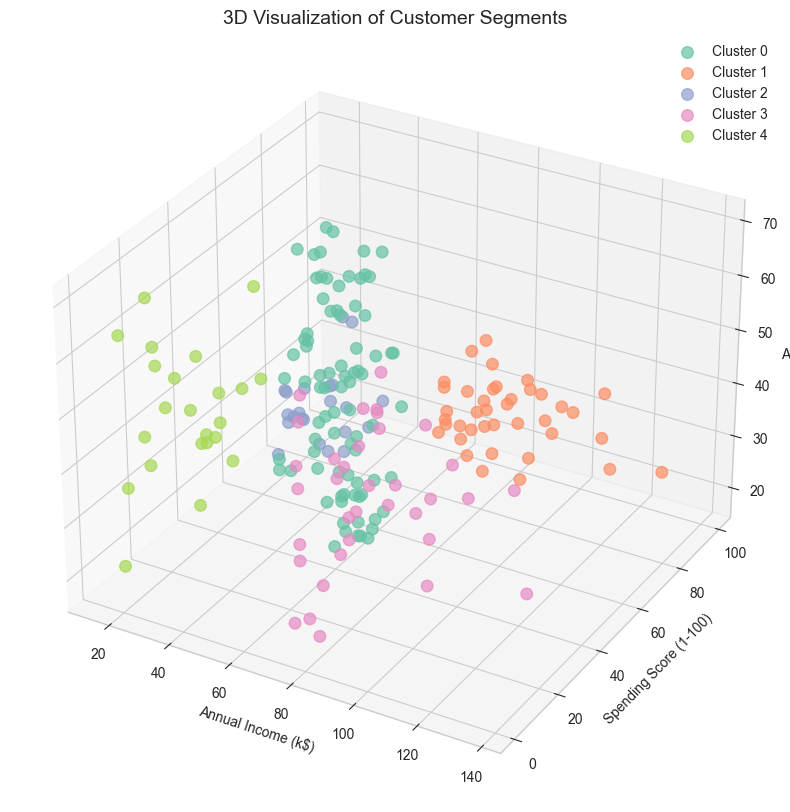

In [20]:
# 5. Visualize in 3D space to see the separation
# ============================================

from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a different color
for cluster_label in range(optimal_k):
    cluster_points = X_features[df['KMeans_Cluster'] == cluster_label]
    ax.scatter(
        cluster_points[:, 1],  # Annual Income
        cluster_points[:, 2],  # Spending Score
        cluster_points[:, 0],  # Age
        alpha=0.7,
        s=70,
        label=f'Cluster {cluster_label}'
    )

ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
ax.set_zlabel('Age')
ax.set_title('3D Visualization of Customer Segments', fontsize=14)
plt.legend()
plt.show()

In [21]:
# 6. Summary and Comparison
# =======================

# Compare K-means and Hierarchical clustering results
comparison = pd.crosstab(
    df['KMeans_Cluster'], 
    df['Hierarchical_Cluster'], 
    rownames=['K-means'], 
    colnames=['Hierarchical']
)

print("\nClustering Method Comparison (Customer Count):")
display(comparison)

# Calculate agreement percentage
agreement = np.sum(np.max(comparison.values, axis=1)) / len(df) * 100
print(f"\nAgreement between K-means and Hierarchical clustering: {agreement:.2f}%")

# Final insights
print("\nFinal Insights:")
print("1. K-means identified customer segments based on income and spending patterns")
print("2. Hierarchical clustering produced similar but slightly different segments")
print("3. Linear SVM was able to classify customers into segments with good accuracy")
print("4. The most important features for segmentation vary by cluster")
print("5. Age, income, and spending score together provide a clear 3D separation of customer segments")


Clustering Method Comparison (Customer Count):


Hierarchical,0,1,2,3,4
K-means,,,,,
0,0,0,81,0,0
1,0,39,0,0,0
2,0,0,1,21,0
3,32,0,3,0,0
4,0,0,0,0,23



Agreement between K-means and Hierarchical clustering: 98.00%

Final Insights:
1. K-means identified customer segments based on income and spending patterns
2. Hierarchical clustering produced similar but slightly different segments
3. Linear SVM was able to classify customers into segments with good accuracy
4. The most important features for segmentation vary by cluster
5. Age, income, and spending score together provide a clear 3D separation of customer segments
